In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Function to analyze and forecast
def analyze_and_forecast(file_path):
    # Load dataset
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()

    # Check if 'price' column exists (mistakenly named)
    if 'Price' not in data.columns:
        print("Dataset columns:", data.columns)
        raise KeyError("Dataset must contain a 'price' column for dates")

    # Rename 'price' column to 'Date' for consistency
    data.rename(columns={'Price': 'Date'}, inplace=True)

    # Convert Date column to datetime and set as index
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna(subset=['Date'])
    data.set_index('Date', inplace=True)

    # Ensure numeric columns
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_columns:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

    # Drop NaN rows
    data = data.dropna()

    # Exploratory Data Analysis
    print("\nDataset Info:")
    print(data.info())
    print("\nDataset Description:")
    print(data.describe())

    # Visualize closing price
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.title('Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # Decompose time series
    decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=30)
    decomposition.plot()
    plt.show()

    # Stationarity test
    result = adfuller(data['Close'])
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

    # Prepare data for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']].values)

    sequence_length = 60
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)

    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build LSTM model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
    plt.plot(data.index[-len(predictions):], predictions, label='Predicted Price', color='red')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    print("Analysis and Forecasting Complete")



/tmp/ipykernel_21/2611561387.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1697 entries, 2018-01-02 to 2024-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1697 non-null   float64
 1   Close      1697 non-null   float64
 2   High       1697 non-null   float64
 3   Low        1697 non-null   float64
 4   Open       1697 non-null   float64
 5   Volume     1697 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 92.8 KB
None

Dataset Description:
         Adj Close        Close         High          Low         Open  \
count  1697.000000  1697.000000  1697.000000  1697.000000  1697.000000   
mean     24.797593    24.828411    25.295239    24.315422    24.823341   
std      29.221442    29.216014    29.811740    28.570804    29.240504   
min       3.151430     3.177000     3.249500     3.111500     3.162250   
25%       6.113620     6.161750     6.250000     6.064250     6.166250   
50%      13.985092 

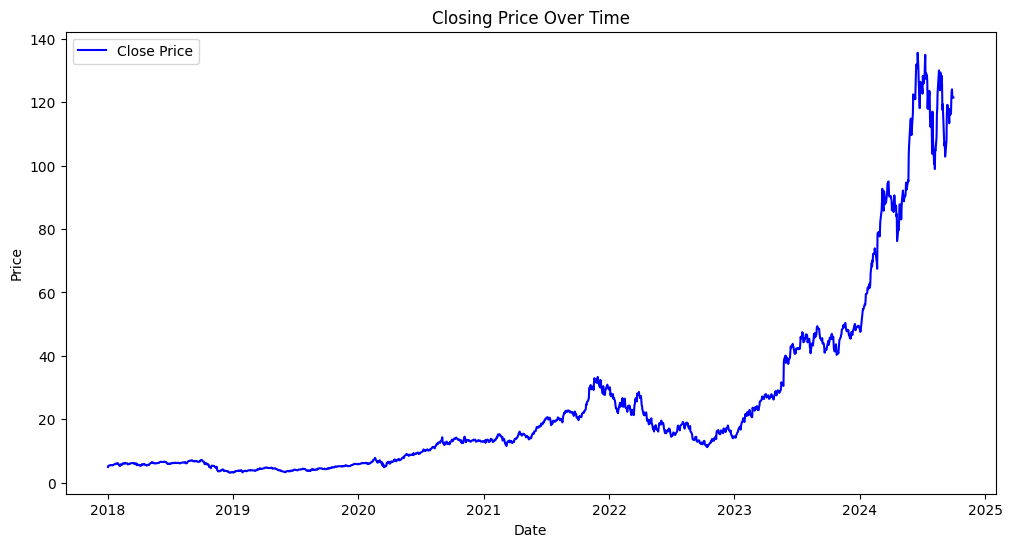

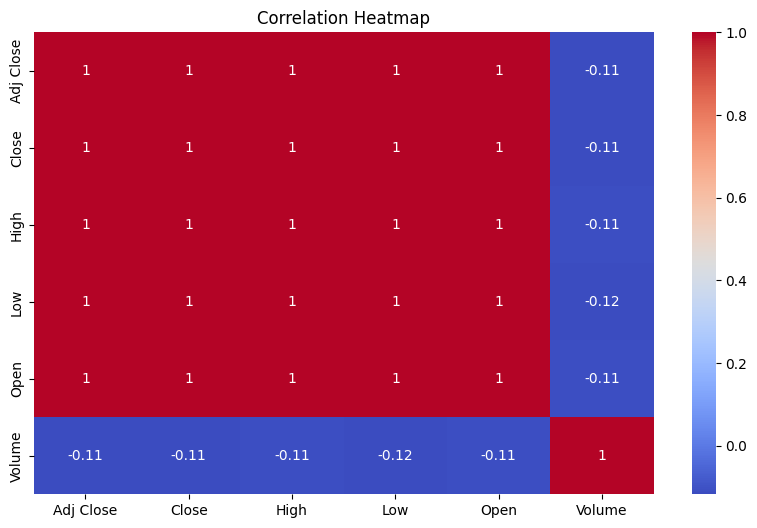

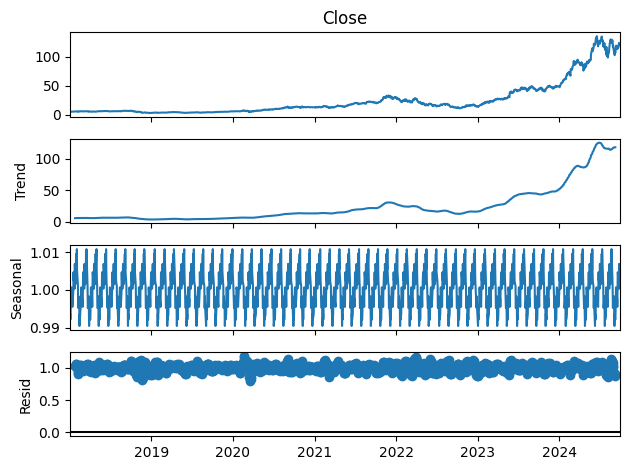


ADF Test Results:
ADF Statistic: 1.63812020339115
p-value: 0.997967550949341
The time series is not stationary.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0045
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 2.5633e-04
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 2.2522e-04
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.8900e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.6949e-04
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 1.6525e-04
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 1.4079e-04
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.4285e-04
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.4784e-04
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 1.6065e-04
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 1.1995e-04
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 1.1456e-04
Epoch 13/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.2476e-04
Epoch 14/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.2570e-04
Epoch 15/20
41/41 ━

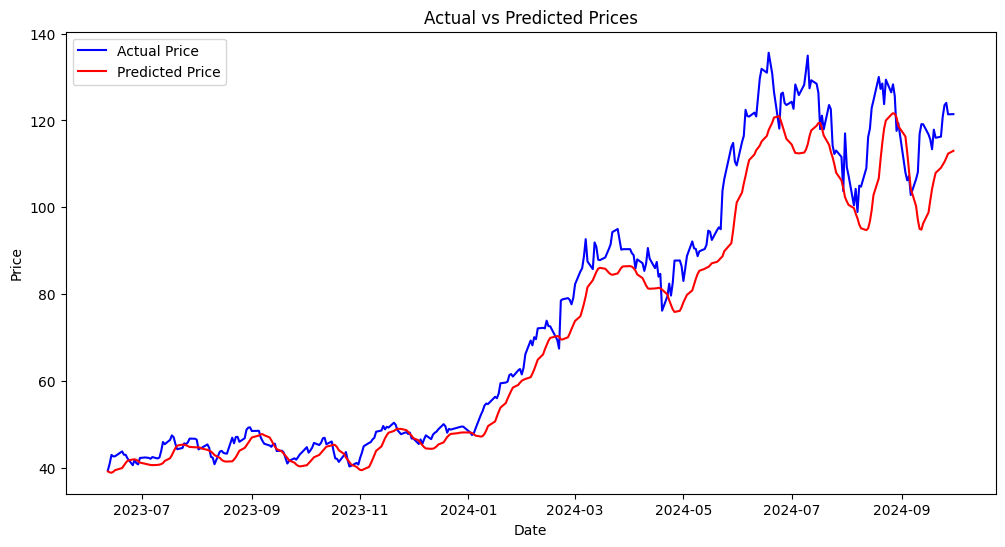

Analysis and Forecasting Complete


In [2]:
# Run the function on your dataset
file_path = '/kaggle/input/nvidia-stock-data/NVIDIA_STOCK.csv'  # Update with the correct path
analyze_and_forecast(file_path)